In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for the yeo-johnson transformation
import scipy.stats as stats

# to save the model
import joblib

In [2]:
# load the unseen / new dataset
data = pd.read_csv('test.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [3]:
# drop the id variable

data.drop('Id', axis=1, inplace=True)

data.shape

(1459, 79)

In [4]:
# first we need to cast MSSubClass as object

data['MSSubClass'] = data['MSSubClass'].astype('O')

In [5]:
# list of different groups of categorical variables

with_string_missing = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature' ]

# ====================================
# we copy this dictionary from the Feature-engineering notebook
# note that we needed to hard-code this by hand

# the key is the variable and the value is its most frequent category
# what if we re-train the model and the below values change ?
# ==================================================

with_frequent_category ={
    'MasVnrType': 'None',
    'BsmtQual': 'TA',
    'BsmtCond': 'TA',
    'BsmtExposure': 'No',
    'BsmtFinType1' : 'Unf',
    'BsmtFinType2' : 'Unf',
    'Electrical' : 'SBrKr',
    'GarageType' : 'Attchd',
    'GarageFinish' : 'Unf',
    'GarageQual' : 'TA',
    'GarageCond' : 'TA',
}

In [6]:
# replace missing values with new label: "Missing"

data[with_string_missing] = data[with_string_missing].fillna('Missing')

In [7]:
# replace missing values with the most frequent category

for var in with_frequent_category.keys():
    data[var].fillna(with_frequent_category[var], inplace=True)

In [8]:
# Missing Numerical variables
# To engineer missing values in numerical variables;
# - add a binary missing value indicator variable
# - the replace the missing values in the original variable with the mean

# this is the dictionary of numerical variables with missing data
# and its mean, as determined from the training set in the
# Feature Engineering notebook

# note how we needed to hard code the values

vars_with_na = {
    'LotFrontage': 69.87974098057354,
    'MasVnrArea': 103.7974006116208,
    'GarageYrBlt': 1978.2959677419356
  
}

In [9]:
# replace missing values as we described above

for var in vars_with_na.keys():

    # add binary missing indicator (in train and test)
    data[var + '_na'] = np.where(data[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    data[var].fillna(vars_with_na[var], inplace=True)

data[vars_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [10]:
# check the binary missing indicator variables

data[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [11]:
# Temporal variables
# capture the time elapsed between those variables and the year in which the house was sold.

def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

In [12]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [13]:
# now we drp YrSold
data.drop(['YrSold'], axis=1, inplace=True)

In [14]:
# Numerical variable transformation
# Logarithmic transformation
# transform the logarithm the positive numerical variables in order to get more Gaussian-like distribution

for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
            data[var] = np.log(data[var])


In [15]:
# Yeo-Johnson transformation
# Apply Yeo-Johnson transformation to LotArea
# note how we use the lambda that we learned from train set

data['LotArea'] = stats.yeojohnson(data['LotArea'], lmbda=12.55283001172003)


In [16]:
# Binarize skewed variables
# Few variables are skewed, transform those into binary variables

skewed  = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:

    # map the variable values into 0 and 1
    data[var] = np.where(data[var]==0, 0, 1)

In [17]:
# Categorical variables
# Apply mappings

# re-map strings to numbers, which determine quality

qual_mappings ={'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = [ 'ExterQual', 'ExterCond', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'BsmtCond',
             'GarageQual', 'GarageCond',
]
for var in qual_vars:
    data[var] = data[var].map(qual_mappings)

In [18]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

data[var] = data[var].map(exposure_mappings)

In [19]:
finish_mappings = {'Missing' : 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mappings)

In [20]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

data[var] = data[var].map(garage_mappings)

In [21]:
fence_mappings = {'Missing': 0, 'NA': 0 , 'MnWw':1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

data[var] = data[var].map(fence_mappings)

In [22]:
# check absence of na in the data set

with_null = [var for var in data.columns if data[var].isnull().sum() > 0]

with_null

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [23]:
# did those have missing data in the train set?

[var for var in with_null if var in list(
    with_frequent_category.keys())+with_string_missing+list(vars_with_na.keys())]

[]

In [24]:
# Removing Rare Labels
# create a dictionary with most frequent categories per variable
# note the amount of hard coding that I need to do

# Can you think of an alternative? Perhaps we could have save this as a numpy pickle
# and load it here, instead of hard-coding.

# But that means that we need to go back to the Feature Engineering notebook, and change
# the code so that we store the pickle. So there is still some code changes that we need


frequent_ls ={
'MSZoning': ['FV', 'RH', 'RL', 'RM'],
    'Street': ['Pave'],
    'Alley': ['Grvl', 'Missing', 'Pave'],
    'LotShape': ['IR1', 'IR2', 'Reg'],
    'LandContour': ['Bnk', 'HLS', 'Low', 'Lvl'],
    'Utilities': ['AllPub'],
    'LotConfig': ['Corner', 'CulDSac', 'FR2', 'Inside'],
    'LandSlope': ['Gtl', 'Mod'],
    'Neighborhood': ['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
                     'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
                     'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
                     'Somerst', 'StoneBr', 'Timber'],

    'Condition1': ['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'],
    'Condition2': ['Norm'],
    'BldgType': ['1Fam', '2fmCon', 'Duplex', 'Twnhs', 'TwnhsE'],
    'HouseStyle': ['1.5Fin', '1Story', '2Story', 'SFoyer', 'SLvl'],
    'RoofStyle': ['Gable', 'Hip'],
    'RoofMatl': ['CompShg'],
    'Exterior1st': ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'],

    'Exterior2nd': ['AsbShng', 'BrkFace', 'CmentBd', 'HdBoard', 'MetalSd', 'Plywood',
                    'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng'],

    'MasVnrType': ['BrkFace', 'None', 'Stone'],
    'Foundation': ['BrkTil', 'CBlock', 'PConc', 'Slab'],
    'Heating': ['GasA', 'GasW'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['FuseA', 'FuseF', 'SBrkr'],
    'Functional': ['Min1', 'Min2', 'Mod', 'Typ'],
    'GarageType': ['Attchd', 'Basment', 'BuiltIn', 'Detchd'],
    'PavedDrive': ['N', 'P', 'Y'],
    'PoolQC': ['Missing'],
    'MiscFeature': ['Missing', 'Shed'],
    'SaleType': ['COD', 'New', 'WD'],
    'SaleCondition': ['Abnorml', 'Family', 'Normal', 'Partial'],
    'MSSubClass': ['20', '30', '50', '60', '70', '75', '80', '85', '90', '120', '160', '190'],
    
    
}

In [25]:
for var in frequent_ls.keys():
    
    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

In [26]:
# Encoding of categorical variables
# we need the mappings learned from the train set. Otherwise, our model is going
# to produce inaccurate results

# note the amount of hard coding that we need to do.

# Can you think of an alternative? 

# Perhaps we could have save this as a numpy pickle
# and load it here, instead of hard-coding.

# But that means that we need to go back to the Feature Engineering notebook, and change
# the code so that we store the pickle. So there is still some code changes that we need

ordinal_mappings = {
    'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
    'Street': {'Rare': 0, 'Pave': 1},
    'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
    'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
    'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
    'Utilities': {'Rare': 0, 'AllPub': 1},
    'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
    'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
    'Neighborhood': {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3,
                     'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7,
                     'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11,
                     'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15,
                     'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19,
                     'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22},
    
    'Condition1': {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5},
    'Condition2': {'Rare': 0, 'Norm': 1},
    'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4},
    'HouseStyle': {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story': 5},
    'RoofStyle': {'Gable': 0, 'Rare': 1, 'Hip': 2},
    'RoofMatl': {'CompShg': 0, 'Rare': 1},
    'Exterior1st': {'AsbShng': 0, 'Wd Sdng': 1, 'WdShing': 2, 'MetalSd': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CemntBd': 9, 'VinylSd': 10},
    
    'Exterior2nd': {'AsbShng': 0, 'Wd Sdng': 1, 'MetalSd': 2, 'Wd Shng': 3,
                    'Stucco': 4, 'Rare': 5, 'HdBoard': 6, 'Plywood': 7,
                    'BrkFace': 8, 'CmentBd': 9, 'VinylSd': 10},
    
    'MasVnrType': {'Rare': 0, 'None': 1, 'BrkFace': 2, 'Stone': 3},
    'Foundation': {'Slab': 0, 'BrkTil': 1, 'CBlock': 2, 'Rare': 3, 'PConc': 4},
    'Heating': {'Rare': 0, 'GasW': 1, 'GasA': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Electrical': {'Rare': 0, 'FuseF': 1, 'FuseA': 2, 'SBrkr': 3},
    'Functional': {'Rare': 0, 'Min2': 1, 'Mod': 2, 'Min1': 3, 'Typ': 4},
    'GarageType': {'Rare': 0, 'Detchd': 1, 'Basment': 2, 'Attchd': 3, 'BuiltIn': 4},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'PoolQC': {'Missing': 0, 'Rare': 1},
    'MiscFeature': {'Rare': 0, 'Shed': 1, 'Missing': 2},
    'SaleType': {'COD': 0, 'Rare': 1, 'WD': 2, 'New': 3},
    'SaleCondition': {'Rare': 0, 'Abnorml': 1, 'Family': 2, 'Normal': 3, 'Partial': 4},
    'MSSubClass': {'30': 0, 'Rare': 1, '190': 2, '90': 3, '160': 4, '50': 5, '85': 6,
                   '70': 7, '80': 8, '20': 9, '75': 10, '120': 11, '60': 12},
}

In [27]:
for var in ordinal_mappings.keys():

    ordinal_label = ordinal_mappings[var]

    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

In [28]:
# check absence of na in the data set

with_null =[var for var in data.columns if data[var].isnull().sum() > 0]

len(with_null)

13

In [29]:
# there is missing data in a lot of the variables.

# unfortunately, the scaler will not work with missing data, so
# we need to fill those values

# in the real world, we would try to understand where they are coming from
# and why they were not present in the training set

# here I will just fill them in quickly to proceed with the demo

data.fillna(0, inplace=True)

In [30]:
data.head()
#print(data)
#data.to_csv('check_data.csv')

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,1,0,4.382027,8.560658e+49,0,0.0,2,0.0,0,3,...,1,3,0,0,6,1,0,0,0,0
1,1,0,4.394449,1.122722e+51,0,0.0,2,0.0,0,3,...,1,0,0,1,6,1,0,0,0,0
2,1,0,4.304065,7.597828e+50,0,0.0,2,0.0,0,3,...,1,3,0,0,3,1,0,0,0,0
3,1,0,4.356709,1.262170e+49,0,0.0,2,0.0,0,3,...,1,0,0,0,6,1,0,0,0,0
4,1,0,3.761200,2.189465e+45,0,0.0,2,0.0,0,3,...,1,0,0,0,1,1,0,0,0,0


In [31]:
# Featuer scaling
# load the scaler we saved in the notebook on Feature Engineering

# fortunataly, we were smart and we saved it, but this is an easy step
# to forget

scaler = joblib.load('minmax_scaler.joblib') 

data = pd.DataFrame(
    scaler.transform(data),
    columns=data.columns
)

In [32]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.083333,0.0,0.495064,8.560658e+49,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0
1,0.083333,0.0,0.499662,1.122722e+51,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,1.0,0.454545,0.333333,0.0,0.0,0.0,0.0
2,0.083333,0.0,0.466207,7.597828e+50,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.75,0.0,0.0,0.181818,0.333333,0.0,0.0,0.0,0.0
3,0.083333,0.0,0.485693,1.262170e+49,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,0.0,0.454545,0.333333,0.0,0.0,0.0,0.0
4,0.083333,0.0,0.265271,2.189465e+45,0.0,0.0,0.666667,0.0,0.0,0.75,...,1.0,0.00,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0


In [33]:
# load the pre-selected features
# ==============================

features =pd.read_csv('selected_features.csv')
features = features['0'].to_list()

# reduce the train and test set to the selected features
data = data[features]

data.shape

(1459, 37)

<AxesSubplot:>

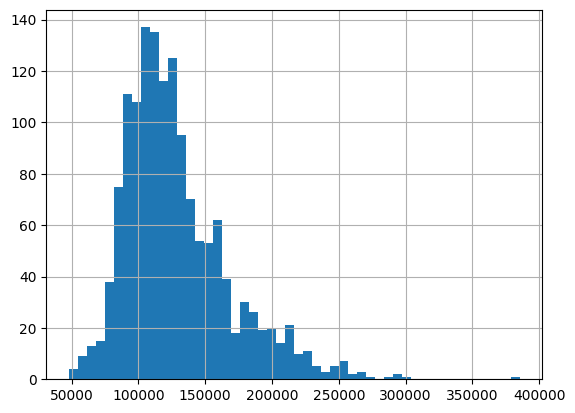

In [34]:
# now let's load the trained model

lin_model = joblib.load('linear_regression.joblib')

# let's obtain the predictions
pred = lin_model.predict(data)

# let's plot the predicted sale prices
pd.Series(np.exp(pred)).hist(bins=50)